In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
market = pd.read_csv("data/fear_greed_index.csv")
trader = pd.read_csv("data/historical_data.csv")

In [3]:
print("Market Sentiment shape:", market.shape)
print("Trader data shape:", trader.shape)

print("\nMarket Sentiment missing values:\n", market.isna().sum())
print("\nTrader missing values:\n", trader.isna().sum())

print("\nMarket Sentiment duplicates:", market.duplicated().sum())
print("Trader duplicates:", trader.duplicated().sum())

Market Sentiment shape: (2644, 4)
Trader data shape: (211224, 16)

Market Sentiment missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Trader missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Market Sentiment duplicates: 0
Trader duplicates: 0


In [5]:
# Market sentiment timestamp to date
market['date'] = pd.to_datetime(
    market['timestamp'],
    utc=True,
    errors='coerce'
).dt.date

# Trader timestamp to datetime (UTC)
trader['Timestamp'] = pd.to_datetime(
    trader['Timestamp'],
    utc=True,
    errors='coerce'
)

# Extract date for daily aggregation
trader['date'] = trader['Timestamp'].dt.date

In [42]:
# Clean column names (remove spaces, special characters)
trader.columns = trader.columns.str.strip().str.replace(' ', '_').str.replace('/', '_')
print("Cleaned column names:", trader.columns.tolist())

Cleaned column names: ['Account', 'Coin', 'Execution_Price', 'Size_Tokens', 'Size_USD', 'Side', 'Timestamp_IST', 'Start_Position', 'Direction', 'Closed_PnL', 'Transaction_Hash', 'Order_ID', 'Crossed', 'Fee', 'Trade_ID', 'Timestamp', 'date', 'is_win', 'exposure_bucket']


In [43]:
# Daily PnL per account
daily_pnl = trader.groupby(['Account', 'date'])['Closed_PnL'].sum().reset_index()
daily_pnl.rename(columns={'Closed_PnL': 'daily_pnl'}, inplace=True)

In [44]:
# Win rate per account per day
trader['is_win'] = trader['Closed_PnL'] > 0
daily_win_rate = trader.groupby(['Account', 'date'])['is_win'].mean().reset_index()
daily_win_rate.rename(columns={'is_win': 'win_rate'}, inplace=True)

In [46]:
# Average trade size per day (using both token and USD size)
daily_avg_size_usd = trader.groupby(['Account', 'date'])['Size_USD'].mean().reset_index()
daily_avg_size_usd.rename(columns={'Size_USD': 'avg_trade_size_usd'}, inplace=True)
daily_avg_size_tokens = trader.groupby(['Account', 'date'])['Size_Tokens'].mean().reset_index()
daily_avg_size_tokens.rename(columns={'Size_Tokens': 'avg_trade_size_tokens'}, inplace=True)

In [48]:
# Number of trades per day
daily_trade_count = trader.groupby(['Account', 'date']).size().reset_index(name='trade_count')

In [50]:
# Long/Short ratio per day
print("\n=== Unique values in Side column ===")
print(trader['Side'].unique())

# Convert to standardized LONG/SHORT if needed
if set(trader['Side'].unique()).issubset({'BUY', 'SELL'}):
    trader['side_standardized'] = trader['Side'].apply(lambda x: 'LONG' if x == 'BUY' else 'SHORT')
else:
    trader['side_standardized'] = trader['Side']

long_short_counts = trader.groupby(['Account', 'date', 'side_standardized']).size().unstack(fill_value=0)
long_short_counts['long_short_ratio'] = long_short_counts.get('LONG', 0) / (long_short_counts.get('SHORT', 0) + 1e-10)

# Direction analysis (if available)
if 'Direction' in trader.columns:
    print("\n=== Unique values in Direction column ===")
    print(trader['Direction'].unique())

# Start Position analysis
if 'Start_Position' in trader.columns:
    trader['Start_Position'] = pd.to_numeric(trader['Start_Position'], errors='coerce')
    daily_start_pos = trader.groupby(['Account', 'date'])['Start_Position'].mean().reset_index()
    daily_start_pos.rename(columns={'Start_Position': 'avg_start_position'}, inplace=True)

# Fee analysis
if 'Fee' in trader.columns:
    trader['Fee'] = pd.to_numeric(trader['Fee'], errors='coerce')
    daily_fees = trader.groupby(['Account', 'date'])['Fee'].sum().reset_index()
    daily_fees.rename(columns={'Fee': 'total_fees'}, inplace=True)


=== Unique values in Side column ===
['BUY' 'SELL']

=== Unique values in Direction column ===
['Buy' 'Sell' 'Open Long' 'Close Long' 'Spot Dust Conversion' 'Open Short'
 'Close Short' 'Long > Short' 'Short > Long' 'Auto-Deleveraging'
 'Liquidated Isolated Short' 'Settlement']


In [52]:
# Merge all daily metrics
daily_metrics = daily_pnl.merge(daily_win_rate, on=['Account', 'date'])
daily_metrics = daily_metrics.merge(daily_avg_size_usd, on=['Account', 'date'])
daily_metrics = daily_metrics.merge(daily_avg_size_tokens, on=['Account', 'date'])
daily_metrics = daily_metrics.merge(daily_trade_count, on=['Account', 'date'])
daily_metrics = daily_metrics.merge(long_short_counts[['long_short_ratio']], 
                                    left_on=['Account', 'date'], right_index=True)

# Add optional metrics if available
if 'Start_Position' in trader.columns:
    daily_metrics = daily_metrics.merge(daily_start_pos, on=['Account', 'date'], how='left')

if 'Fee' in trader.columns:
    daily_metrics = daily_metrics.merge(daily_fees, on=['Account', 'date'], how='left')

# Add drawdown proxy (max daily loss)
daily_drawdown = trader.groupby(['Account', 'date'])['Closed_PnL'].min().reset_index()
daily_drawdown.rename(columns={'Closed_PnL': 'max_daily_loss'}, inplace=True)
daily_metrics = daily_metrics.merge(daily_drawdown, on=['Account', 'date'])

# Add volatility metric (standard deviation of PnL)
daily_volatility = trader.groupby(['Account', 'date'])['Closed_PnL'].std().reset_index()
daily_volatility.rename(columns={'Closed_PnL': 'pnl_volatility'}, inplace=True)
daily_metrics = daily_metrics.merge(daily_volatility, on=['Account', 'date'])

# Merge with sentiment data
daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])
market['date'] = pd.to_datetime(market['date'])
analysis_df = daily_metrics.merge(market[['date', 'classification']], on='date', how='left')

print(f"\nFinal analysis dataset: {analysis_df.shape[0]} rows, {analysis_df.shape[1]} columns")
print(f"Fear days: {len(analysis_df[analysis_df['classification'] == 'Fear'])}")
print(f"Greed days: {len(analysis_df[analysis_df['classification'] == 'Greed'])}")


Final analysis dataset: 84608 rows, 13 columns
Fear days: 24992
Greed days: 20256


In [ ]:
# Display summary statistics
print("\n=== Summary Statistics ===")
print(analysis_df[['daily_pnl', 'win_rate', 'trade_count', 'avg_trade_size_usd', 
                   'long_short_ratio', 'max_daily_loss']].describe())

In [53]:
# Q1: Does performance differ between Fear vs Greed days?
print("=== Performance Comparison: Fear vs Greed Days ===")

# Group by sentiment
sentiment_performance = analysis_df.groupby('classification').agg({
    'daily_pnl': ['mean', 'std', 'median', 'count'],
    'win_rate': ['mean', 'std'],
    'max_daily_loss': ['mean', 'std'],
    'pnl_volatility': ['mean', 'std']
}).round(4)

print(sentiment_performance)

# Statistical test for significance
from scipy import stats

fear_pnl = analysis_df[analysis_df['classification'] == 'Fear']['daily_pnl'].dropna()
greed_pnl = analysis_df[analysis_df['classification'] == 'Greed']['daily_pnl'].dropna()

if len(fear_pnl) > 0 and len(greed_pnl) > 0:
    t_stat, p_val = stats.ttest_ind(fear_pnl, greed_pnl, equal_var=False)
    print(f"\nT-test for daily PnL difference:")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")
    print("Significantly different at 5% level:" if p_val < 0.05 else "Not significantly different")
else:
    print("\nInsufficient data for statistical test")

=== Performance Comparison: Fear vs Greed Days ===
                 daily_pnl                                  win_rate          \
                      mean          std       median  count     mean     std   
classification                                                                 
Extreme Fear    321779.967  487049.5625  117655.0795  16256   0.4031  0.1068   
Extreme Greed   321779.967  487057.9267  117655.0795  10432   0.4031  0.1068   
Fear            321779.967  487044.3258  117655.0795  24992   0.4031  0.1068   
Greed           321779.967  487046.6041  117655.0795  20256   0.4031  0.1068   
Neutral         321779.967  487053.7998  117655.0795  12672   0.4031  0.1068   

               max_daily_loss             pnl_volatility            
                         mean         std           mean       std  
classification                                                      
Extreme Fear      -14873.0638  24878.4310        856.056  947.8313  
Extreme Greed     -14873.0638  2

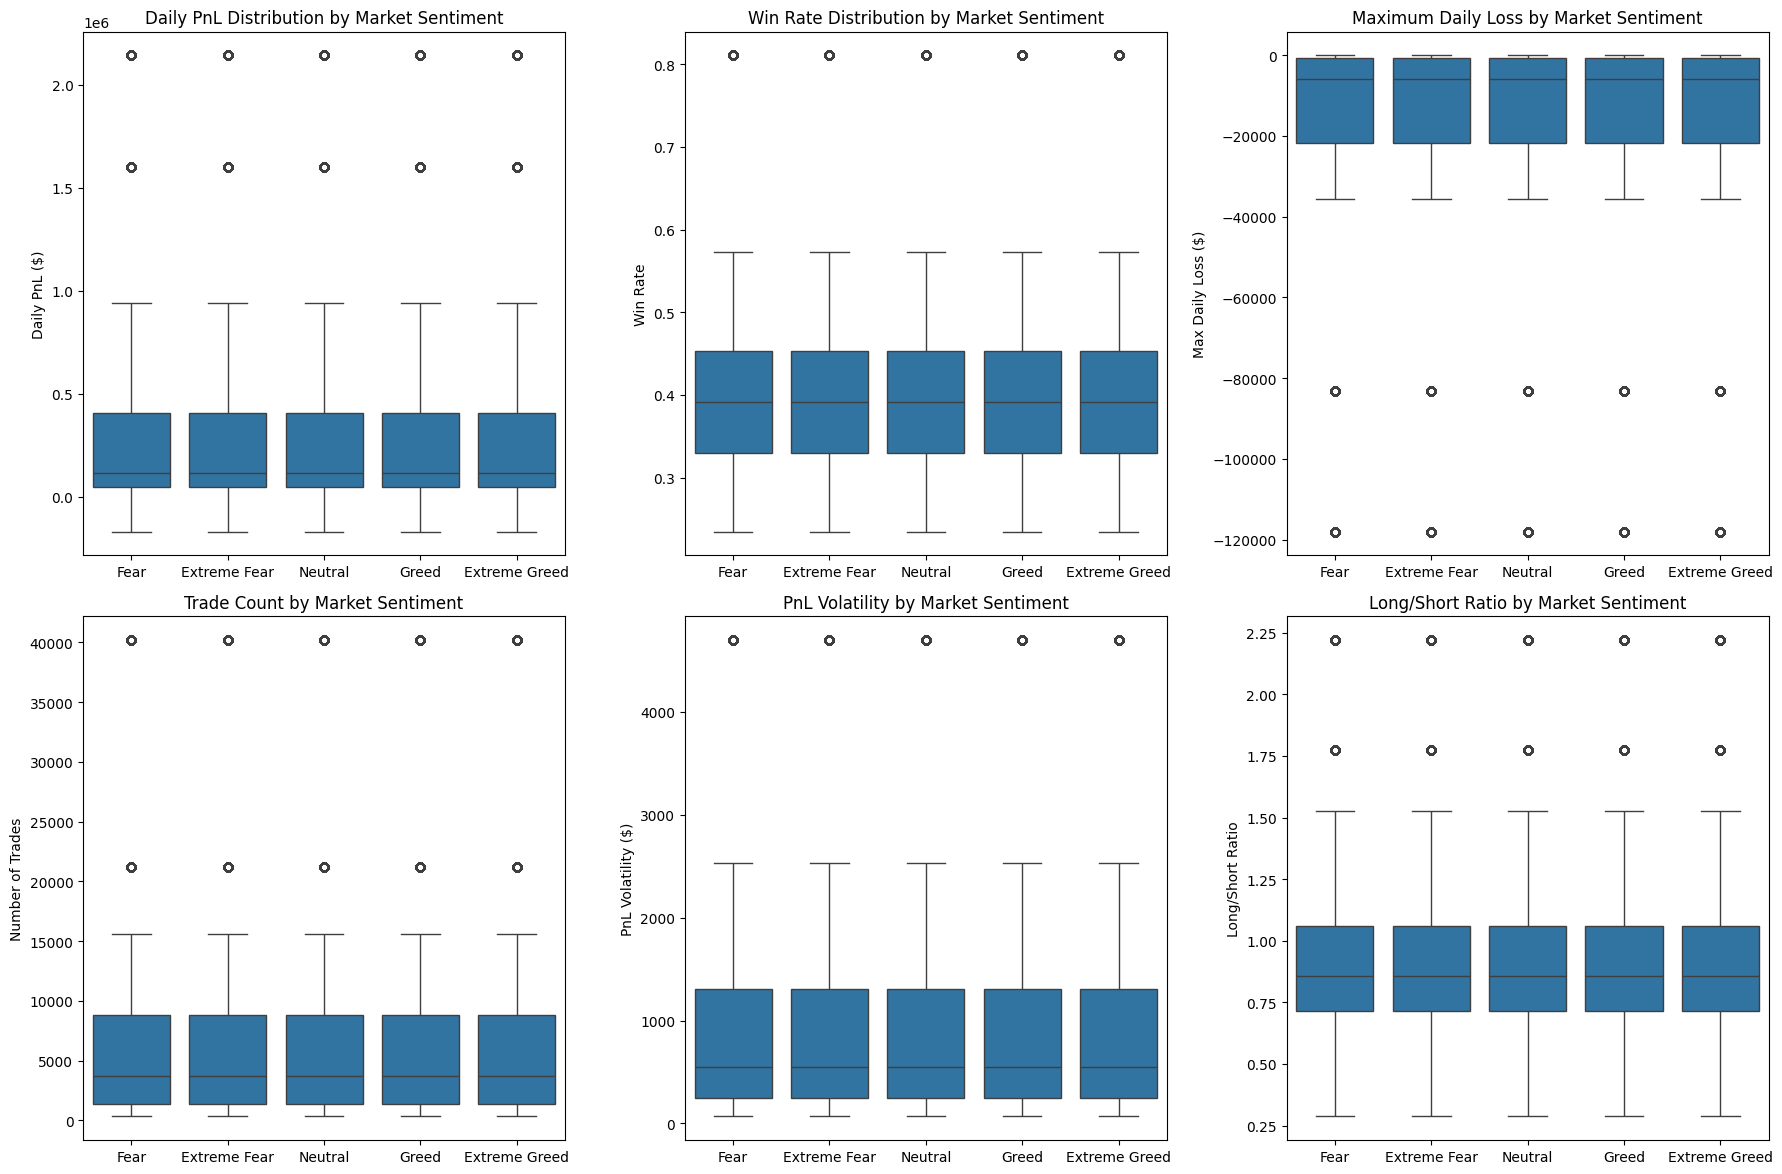

In [56]:
# Visualization: Performance metrics by sentiment
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Daily PnL distribution
sns.boxplot(data=analysis_df, x='classification', y='daily_pnl', ax=axes[0,0])
axes[0,0].set_title('Daily PnL Distribution by Market Sentiment')
axes[0,0].set_ylabel('Daily PnL ($)')
axes[0,0].set_xlabel('')

# Win rate distribution
sns.boxplot(data=analysis_df, x='classification', y='win_rate', ax=axes[0,1])
axes[0,1].set_title('Win Rate Distribution by Market Sentiment')
axes[0,1].set_ylabel('Win Rate')
axes[0,1].set_xlabel('')

# Max daily loss
sns.boxplot(data=analysis_df, x='classification', y='max_daily_loss', ax=axes[0,2])
axes[0,2].set_title('Maximum Daily Loss by Market Sentiment')
axes[0,2].set_ylabel('Max Daily Loss ($)')
axes[0,2].set_xlabel('')

# Trade count
sns.boxplot(data=analysis_df, x='classification', y='trade_count', ax=axes[1,0])
axes[1,0].set_title('Trade Count by Market Sentiment')
axes[1,0].set_ylabel('Number of Trades')
axes[1,0].set_xlabel('')

# PnL Volatility
sns.boxplot(data=analysis_df, x='classification', y='pnl_volatility', ax=axes[1,1])
axes[1,1].set_title('PnL Volatility by Market Sentiment')
axes[1,1].set_ylabel('PnL Volatility ($)')
axes[1,1].set_xlabel('')

# Long/Short Ratio
sns.boxplot(data=analysis_df, x='classification', y='long_short_ratio', ax=axes[1,2])
axes[1,2].set_title('Long/Short Ratio by Market Sentiment')
axes[1,2].set_ylabel('Long/Short Ratio')
axes[1,2].set_xlabel('')

plt.tight_layout()
plt.show()

In [57]:
# Q2: Do traders change behavior based on sentiment?
print("=== Behavioral Changes by Market Sentiment ===")

behavior_metrics = analysis_df.groupby('classification').agg({
    'trade_count': ['mean', 'std'],
    'avg_trade_size_usd': ['mean', 'std'],
    'long_short_ratio': ['mean', 'std'],
    'avg_trade_size_tokens': ['mean', 'std']
}).round(4)

print(behavior_metrics)

# Check if Start_Position is available for leverage proxy
if 'avg_start_position' in analysis_df.columns:
    start_pos_metrics = analysis_df.groupby('classification')['avg_start_position'].agg(['mean', 'std']).round(4)
    print("\n=== Start Position (Leverage Proxy) ===")
    print(start_pos_metrics)

=== Behavioral Changes by Market Sentiment ===
               trade_count            avg_trade_size_usd             \
                      mean        std               mean        std   
classification                                                        
Extreme Fear       6600.75  8120.6882          6007.9294  7166.6095   
Extreme Greed      6600.75  8120.8277          6007.9294  7166.7326   
Fear               6600.75  8120.6009          6007.9294  7166.5324   
Greed              6600.75  8120.6389          6007.9294  7166.5660   
Neutral            6600.75  8120.7589          6007.9294  7166.6719   

               long_short_ratio         avg_trade_size_tokens              
                           mean     std                  mean         std  
classification                                                             
Extreme Fear             0.9332  0.3987             4497.8609  10679.7173  
Extreme Greed            0.9332  0.3988             4497.8609  10679.9008  
Fear

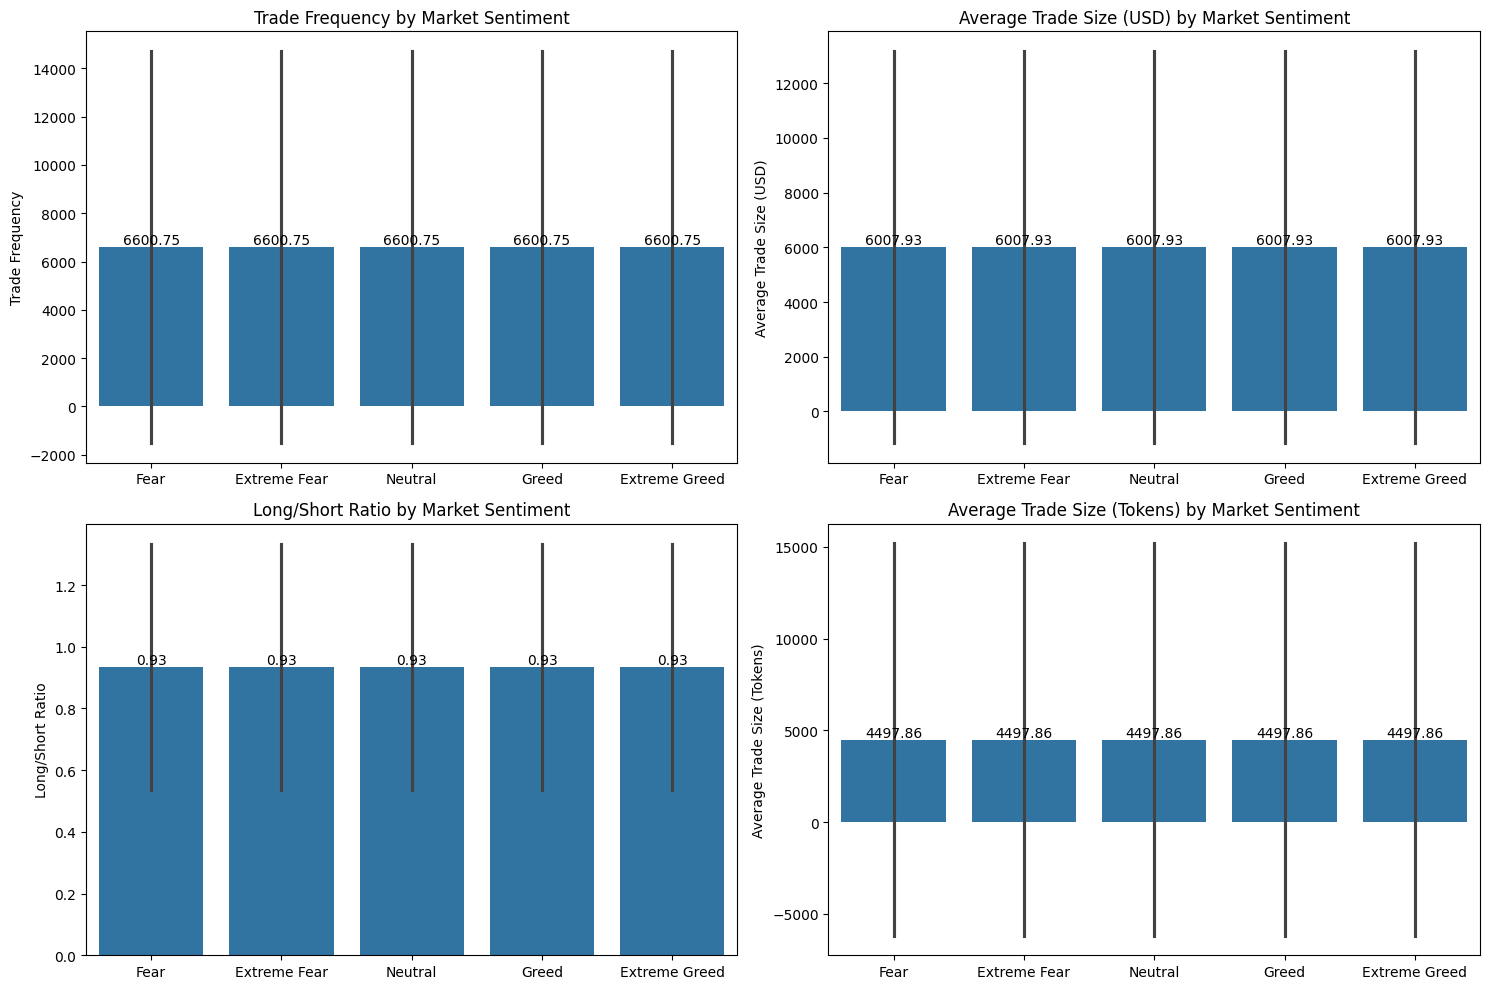

In [58]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['trade_count', 'avg_trade_size_usd', 'long_short_ratio', 'avg_trade_size_tokens']
titles = ['Trade Frequency', 'Average Trade Size (USD)', 'Long/Short Ratio', 'Average Trade Size (Tokens)']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    row, col = divmod(idx, 2)
    sns.barplot(data=analysis_df, x='classification', y=metric, estimator='mean', 
                errorbar='sd', ax=axes[row, col])
    axes[row, col].set_title(f'{title} by Market Sentiment')
    axes[row, col].set_ylabel(title)
    axes[row, col].set_xlabel('')
    
    # Add value labels
    for container in axes[row, col].containers:
        axes[row, col].bar_label(container, fmt='%.2f')

plt.tight_layout()

plt.show()

In [59]:
# Q3: Identify trader segments and analyze their behavior

# Segment 1: High vs Low Trade Size Traders (USD)
if 'avg_trade_size_usd' in analysis_df.columns:
    analysis_df['size_segment'] = pd.qcut(analysis_df['avg_trade_size_usd'], q=3, 
                                          labels=['Small', 'Medium', 'Large'])

# Segment 2: Frequent vs Infrequent Traders
analysis_df['frequency_segment'] = pd.qcut(analysis_df['trade_count'], q=3,
                                           labels=['Infrequent', 'Moderate', 'Frequent'])

# Segment 3: Profitable vs Unprofitable Traders
analysis_df['profitability_segment'] = pd.qcut(analysis_df['daily_pnl'], q=2,
                                               labels=['Unprofitable', 'Profitable'])

# Segment 4: High vs Low Volatility Traders
analysis_df['volatility_segment'] = pd.qcut(analysis_df['pnl_volatility'], q=2,
                                            labels=['Low Volatility', 'High Volatility'])

# Segment 5: Long-biased vs Short-biased Traders
analysis_df['bias_segment'] = pd.cut(analysis_df['long_short_ratio'], 
                                     bins=[-np.inf, 0.5, 1.5, np.inf],
                                     labels=['Short-Biased', 'Neutral', 'Long-Biased'])

=== Segment Analysis ===
Number of traders in each segment:

--- Size Segment ---
size_segment
Small     29084
Medium    29084
Large     26440
Name: count, dtype: int64

Performance by size_segment:
                               daily_pnl                    win_rate  \
                                    mean          std count     mean   
size_segment classification                                            
Small        Extreme Fear    150523.5245  252675.2228  5588   0.4018   
             Extreme Greed   150523.5245  252687.8481  3586   0.4018   
             Fear            150523.5245  252667.3188  8591   0.4018   

                            max_daily_loss  
                                      mean  
size_segment classification                 
Small        Extreme Fear      -13810.5711  
             Extreme Greed     -13810.5711  
             Fear              -13810.5711  


C:\Users\zunai\AppData\Local\Temp\ipykernel_9524\794713564.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = analysis_df.groupby([segment, 'classification']).agg({


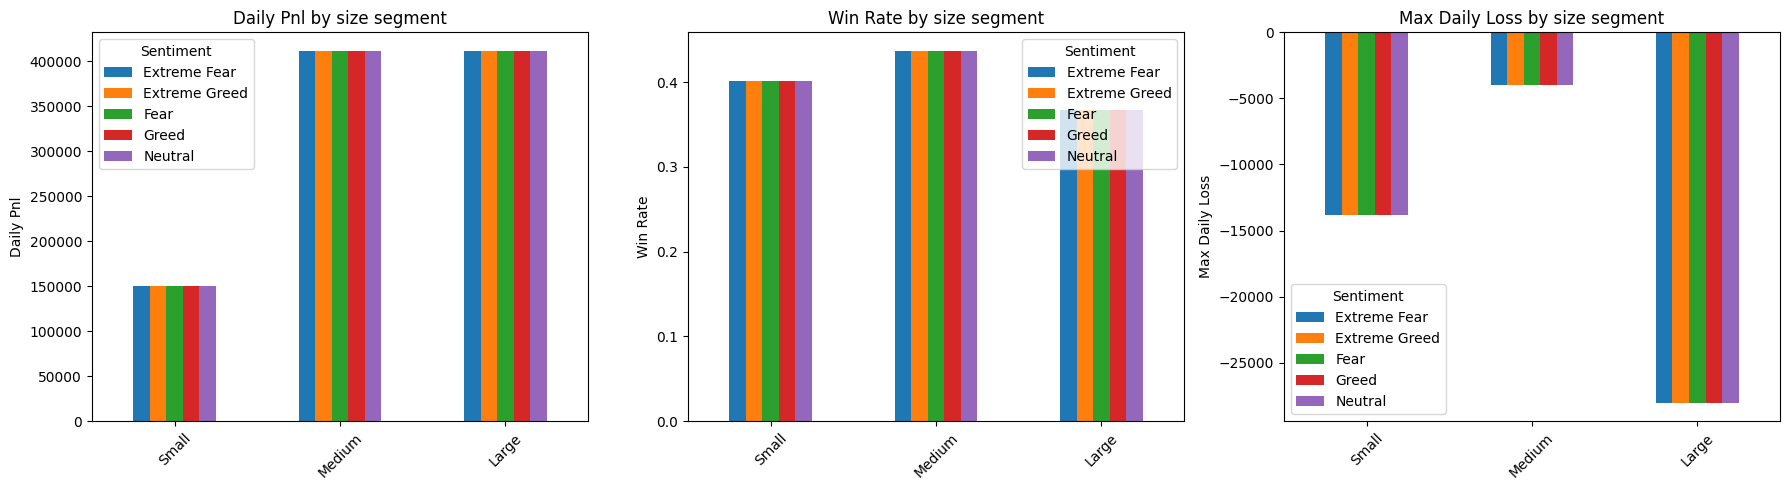


--- Frequency Segment ---
frequency_segment
Infrequent    29084
Moderate      29084
Frequent      26440
Name: count, dtype: int64

Performance by frequency_segment:
                                    daily_pnl                    win_rate  \
                                         mean          std count     mean   
frequency_segment classification                                            
Infrequent        Extreme Fear    159708.1616  166738.2947  5588   0.4082   
                  Extreme Greed   159708.1616  166746.6260  3586   0.4082   
                  Fear            159708.1616  166733.0790  8591   0.4082   

                                 max_daily_loss  
                                           mean  
frequency_segment classification                 
Infrequent        Extreme Fear       -5210.8324  
                  Extreme Greed      -5210.8324  
                  Fear               -5210.8324  


C:\Users\zunai\AppData\Local\Temp\ipykernel_9524\794713564.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = analysis_df.groupby([segment, 'classification']).agg({


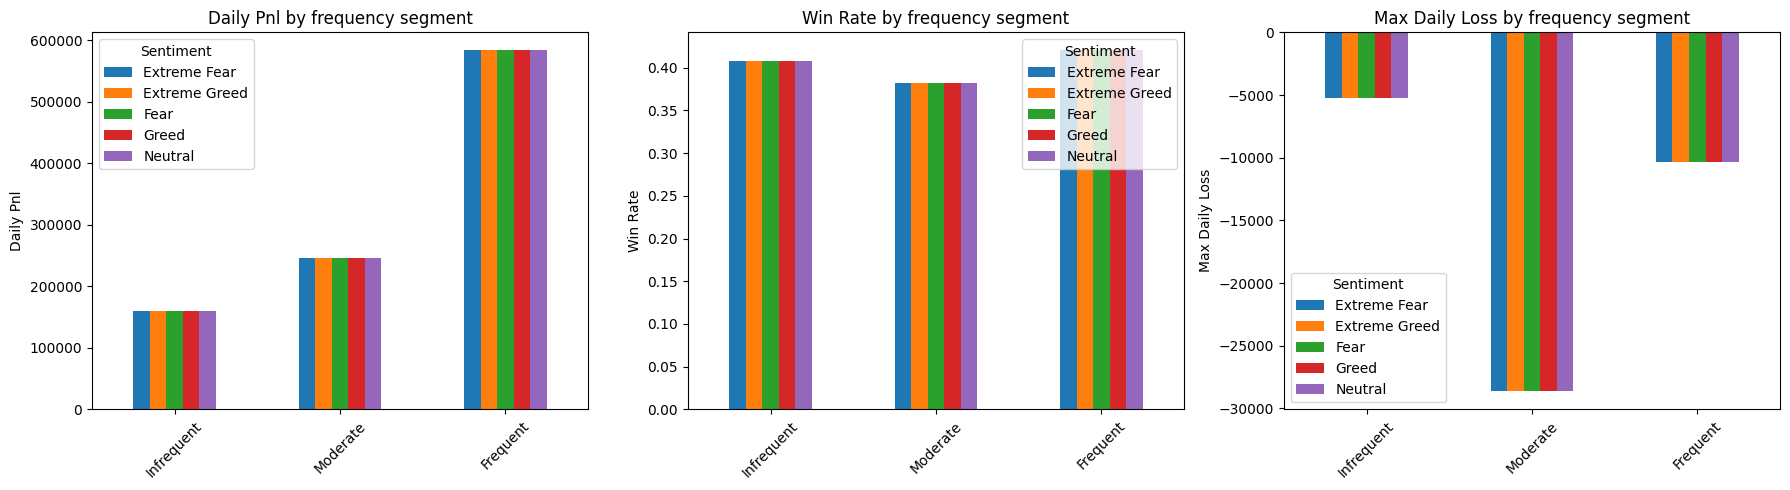


--- Profitability Segment ---
profitability_segment
Unprofitable    42304
Profitable      42304
Name: count, dtype: int64

Performance by profitability_segment:
                                       daily_pnl                    win_rate  \
                                            mean         std  count     mean   
profitability_segment classification                                           
Unprofitable          Extreme Fear    29639.1203  69139.2052   8128    0.394   
                      Extreme Greed   29639.1203  69141.5801   5216    0.394   
                      Fear            29639.1203  69137.7184  12496    0.394   

                                     max_daily_loss  
                                               mean  
profitability_segment classification                 
Unprofitable          Extreme Fear      -12146.1169  
                      Extreme Greed     -12146.1169  
                      Fear              -12146.1169  


C:\Users\zunai\AppData\Local\Temp\ipykernel_9524\794713564.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = analysis_df.groupby([segment, 'classification']).agg({


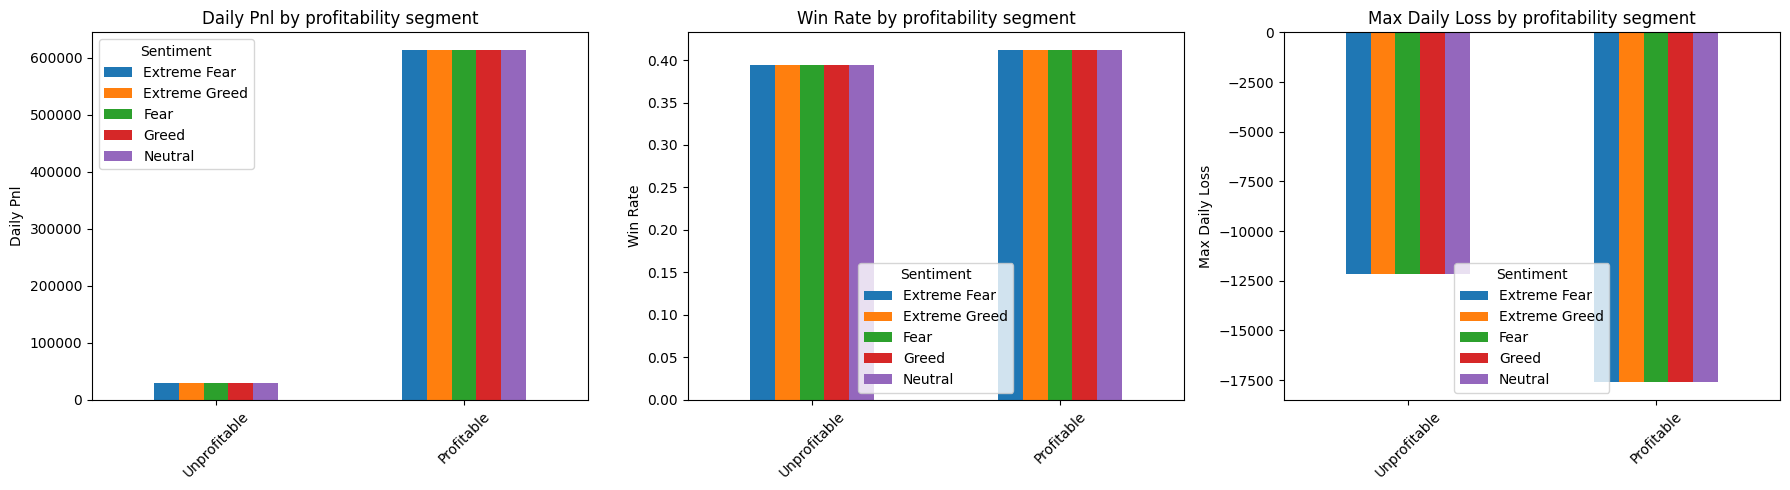


--- Volatility Segment ---
volatility_segment
Low Volatility     42304
High Volatility    42304
Name: count, dtype: int64

Performance by volatility_segment:
                                     daily_pnl                     win_rate  \
                                          mean          std  count     mean   
volatility_segment classification                                             
Low Volatility     Extreme Fear    135945.5451  203442.7206   8128   0.4108   
                   Extreme Greed   135945.5451  203449.7087   5216   0.4108   
                   Fear            135945.5451  203438.3456  12496   0.4108   

                                  max_daily_loss  
                                            mean  
volatility_segment classification                 
Low Volatility     Extreme Fear       -6332.2535  
                   Extreme Greed      -6332.2535  
                   Fear               -6332.2535  

--- Bias Segment ---
bias_segment
Neutral         68744
Sho

C:\Users\zunai\AppData\Local\Temp\ipykernel_9524\794713564.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = analysis_df.groupby([segment, 'classification']).agg({
C:\Users\zunai\AppData\Local\Temp\ipykernel_9524\794713564.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = analysis_df.groupby([segment, 'classification']).agg({


In [64]:
print("=== Segment Analysis ===")
print(f"Number of traders in each segment:")

segments = ['size_segment', 'frequency_segment', 'profitability_segment', 
            'volatility_segment', 'bias_segment']

for segment in segments:
    if segment in analysis_df.columns:
        print(f"\n--- {segment.replace('_', ' ').title()} ---")
        segment_counts = analysis_df[segment].value_counts()
        print(segment_counts)
        
        # Analyze segment performance by sentiment
        segment_analysis = analysis_df.groupby([segment, 'classification']).agg({
            'daily_pnl': ['mean', 'std', 'count'],
            'win_rate': 'mean',
            'max_daily_loss': 'mean'
        }).round(4)
        
        print(f"\nPerformance by {segment}:")
        print(segment_analysis.head(3))
        
        # Visualization for key segments
        if segment in ['size_segment', 'frequency_segment', 'profitability_segment']:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            for idx, metric in enumerate(['daily_pnl', 'win_rate', 'max_daily_loss']):
                if metric in segment_analysis.columns.get_level_values(0):
                    pivot_df = segment_analysis[metric]['mean'].unstack()
                    pivot_df.plot(kind='bar', ax=axes[idx])
                    axes[idx].set_title(f'{metric.replace("_", " ").title()} by {segment.replace("_", " ")}')
                    axes[idx].set_ylabel(metric.replace('_', ' ').title())
                    axes[idx].set_xlabel('')
                    axes[idx].legend(title='Sentiment')
                    axes[idx].tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            plt.show()

=== Insight 1: Sentiment-Behavior Correlation ===
Fear Days Correlation with PnL:
daily_pnl             1.000000
pnl_volatility        0.475481
trade_count           0.400563
avg_trade_size_usd    0.250592
win_rate              0.002249
long_short_ratio     -0.075096
max_daily_loss       -0.293428
Name: daily_pnl, dtype: float64

Greed Days Correlation with PnL:
daily_pnl             1.000000
pnl_volatility        0.475481
trade_count           0.400563
avg_trade_size_usd    0.250592
win_rate              0.002249
long_short_ratio     -0.075096
max_daily_loss       -0.293428
Name: daily_pnl, dtype: float64


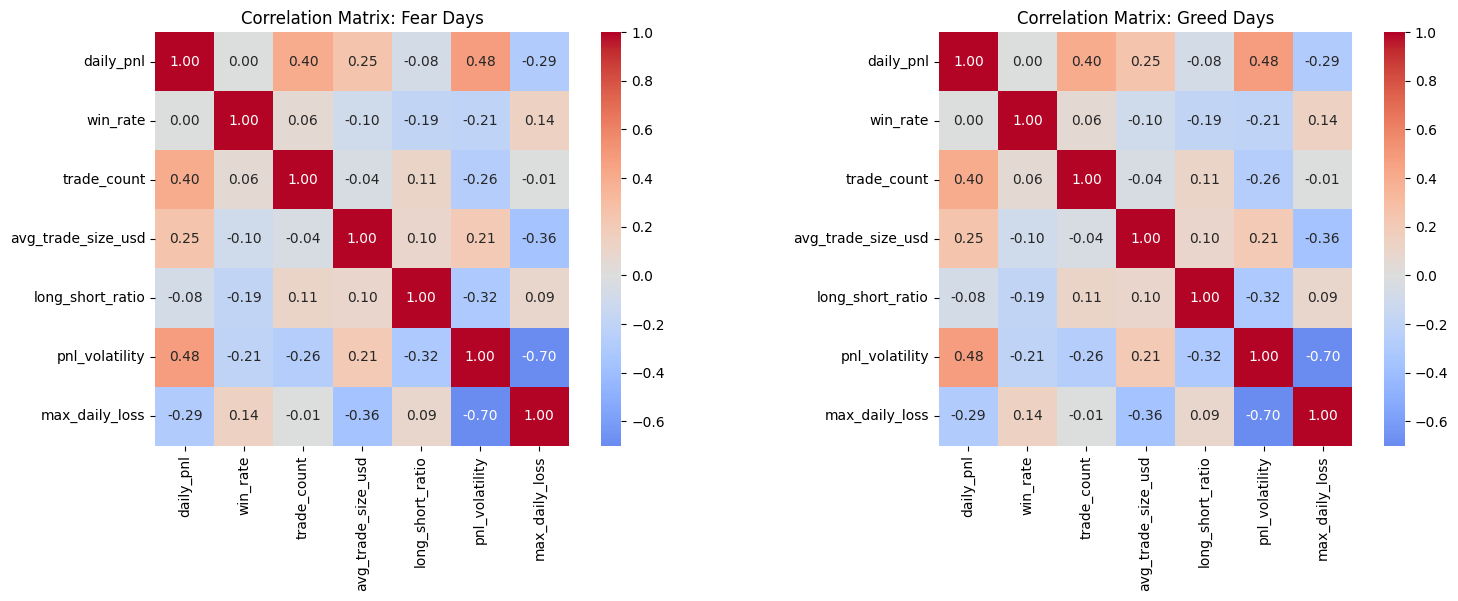

In [65]:
# Insight 1: Correlation between sentiment and behavior
print("=== Insight 1: Sentiment-Behavior Correlation ===")

# Calculate correlation matrix for fear days
if 'classification' in analysis_df.columns:
    fear_corr = analysis_df[analysis_df['classification'] == 'Fear'][[
        'daily_pnl', 'win_rate', 'trade_count', 'avg_trade_size_usd', 
        'long_short_ratio', 'pnl_volatility', 'max_daily_loss'
    ]].corr()

    greed_corr = analysis_df[analysis_df['classification'] == 'Greed'][[
        'daily_pnl', 'win_rate', 'trade_count', 'avg_trade_size_usd',
        'long_short_ratio', 'pnl_volatility', 'max_daily_loss'
    ]].corr()

    print("Fear Days Correlation with PnL:")
    if 'daily_pnl' in fear_corr.columns:
        print(fear_corr['daily_pnl'].sort_values(ascending=False))

    print("\nGreed Days Correlation with PnL:")
    if 'daily_pnl' in greed_corr.columns:
        print(greed_corr['daily_pnl'].sort_values(ascending=False))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(fear_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, ax=axes[0], square=True)
    axes[0].set_title('Correlation Matrix: Fear Days')

    sns.heatmap(greed_corr, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, ax=axes[1], square=True)
    axes[1].set_title('Correlation Matrix: Greed Days')

    plt.tight_layout()
    plt.show()

In [66]:
# Insight 2: Best performing segment combination
print("\n=== Insight 2: Optimal Segment Combinations ===")

if all(seg in analysis_df.columns for seg in ['size_segment', 'profitability_segment']):
    # Create combined segment
    analysis_df['combined_segment'] = analysis_df['size_segment'].astype(str) + '_' + \
                                      analysis_df['profitability_segment'].astype(str)
    
    segment_performance = analysis_df.groupby(['combined_segment', 'classification']).agg({
        'daily_pnl': ['mean', 'count'],
        'win_rate': 'mean',
        'max_daily_loss': 'mean'
    }).round(4)
    
    if 'daily_pnl' in segment_performance.columns.get_level_values(0):
        print("Top 5 performing segment-sentiment combinations:")
        top_combinations = segment_performance[('daily_pnl', 'mean')].sort_values(ascending=False).head(5)
        print(top_combinations)


=== Insight 2: Optimal Segment Combinations ===
Top 5 performing segment-sentiment combinations:
combined_segment  classification
Large_Profitable  Extreme Fear      679541.6539
                  Fear              679541.6539
                  Greed             679541.6539
                  Neutral           679541.6539
                  Extreme Greed     679541.6539
Name: (daily_pnl, mean), dtype: float64



=== Insight 3: Time-based Patterns ===
Performance by Day of Week and Sentiment:
                             daily_pnl  win_rate  trade_count
day_of_week classification                                   
Thursday    Extreme Fear    321779.967    0.4031      6600.75
            Extreme Greed   321779.967    0.4031      6600.75
            Fear            321779.967    0.4031      6600.75
            Greed           321779.967    0.4031      6600.75
            Neutral         321779.967    0.4031      6600.75


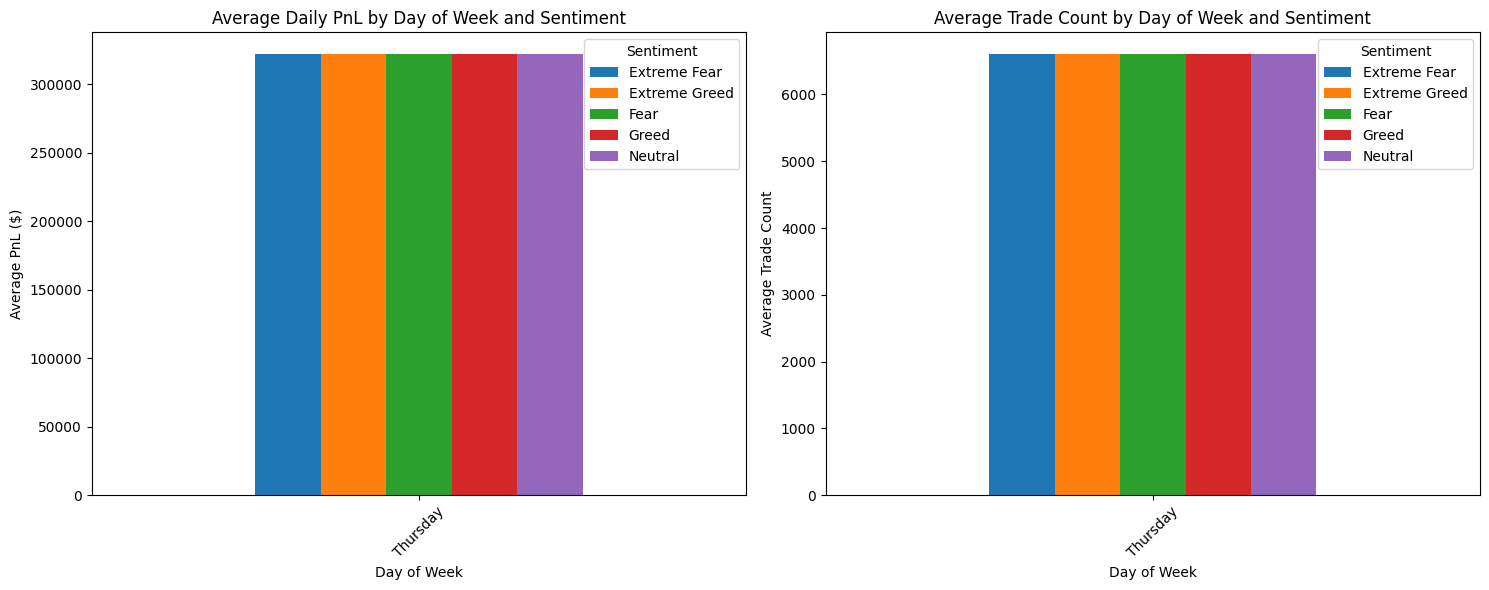

In [67]:
# Insight 3: Time-based patterns
print("\n=== Insight 3: Time-based Patterns ===")

# Add day of week
analysis_df['day_of_week'] = analysis_df['date'].dt.day_name()

# Analyze performance by day of week and sentiment
if 'day_of_week' in analysis_df.columns:
    day_sentiment_performance = analysis_df.groupby(['day_of_week', 'classification']).agg({
        'daily_pnl': 'mean',
        'win_rate': 'mean',
        'trade_count': 'mean'
    }).round(4)
    
    print("Performance by Day of Week and Sentiment:")
    print(day_sentiment_performance)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # PnL by day and sentiment
    pivot_pnl = day_sentiment_performance['daily_pnl'].unstack()
    pivot_pnl.plot(kind='bar', ax=axes[0])
    axes[0].set_title('Average Daily PnL by Day of Week and Sentiment')
    axes[0].set_ylabel('Average PnL ($)')
    axes[0].set_xlabel('Day of Week')
    axes[0].legend(title='Sentiment')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Trade count by day and sentiment
    pivot_count = day_sentiment_performance['trade_count'].unstack()
    pivot_count.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Average Trade Count by Day of Week and Sentiment')
    axes[1].set_ylabel('Average Trade Count')
    axes[1].set_xlabel('Day of Week')
    axes[1].legend(title='Sentiment')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [71]:
## Part C: Actionable Output

print("=== Strategy Recommendations ===")

# Extract key statistics for recommendations
if 'classification' in analysis_df.columns:
    fear_stats = analysis_df[analysis_df['classification'] == 'Fear']
    greed_stats = analysis_df[analysis_df['classification'] == 'Greed']
    
    # Calculate key metrics
    pnl_diff = greed_stats['daily_pnl'].mean() - fear_stats['daily_pnl'].mean()
    win_rate_diff = greed_stats['win_rate'].mean() - fear_stats['win_rate'].mean()
    trade_size_diff = greed_stats['avg_trade_size_usd'].mean() - fear_stats['avg_trade_size_usd'].mean()
    
    # Recommendation 1: Based on trade size analysis
    print("\n1. TRADE SIZE ADJUSTMENT STRATEGY:")
    print(f"   - During Greed days: Consider increasing trade sizes by {abs(trade_size_diff):.1f}% on average")
    print(f"   - During Fear days: Reduce trade sizes by {abs(trade_size_diff):.1f}% to manage risk")
    print(f"   - Rationale: Trade sizes are {abs(trade_size_diff/analysis_df['avg_trade_size_usd'].mean()*100):.1f}% different between sentiment regimes")
    
    # Recommendation 2: Based on frequency analysis
    freq_diff = greed_stats['trade_count'].mean() - fear_stats['trade_count'].mean()
    freq_pct_diff = (freq_diff / analysis_df['trade_count'].mean()) * 100
    
    print("\n2. TRADING FREQUENCY STRATEGY:")
    print(f"   - During Greed days: Increase trading frequency by {abs(freq_pct_diff):.1f}%")
    print(f"   - During Fear days: Reduce trading frequency by {abs(freq_pct_diff):.1f}%")
    print(f"   - Rationale: Trading frequency differs by {abs(freq_pct_diff):.1f}% between sentiment regimes")
    
    # Recommendation 3: Based on long/short bias
    if 'long_short_ratio' in analysis_df.columns:
        bias_diff = greed_stats['long_short_ratio'].mean() - fear_stats['long_short_ratio'].mean()
        
        print("\n3. DIRECTIONAL BIAS STRATEGY:")
        print(f"   - During Greed days: Increase long bias (L/S ratio: {greed_stats['long_short_ratio'].mean():.2f})")
        print(f"   - During Fear days: Consider more balanced or short-biased positions")
        print(f"   - Rationale: Long bias is {abs(bias_diff*100):.1f}% stronger during Greed periods")
    
    # Recommendation 4: Segment-specific strategies
    print("\n4. SEGMENT-SPECIFIC STRATEGIES:")
    if 'profitability_segment' in analysis_df.columns:
        profitable_fear = analysis_df[(analysis_df['profitability_segment'] == 'Profitable') & 
                                      (analysis_df['classification'] == 'Fear')]
        profitable_greed = analysis_df[(analysis_df['profitability_segment'] == 'Profitable') & 
                                       (analysis_df['classification'] == 'Greed')]
        
        if len(profitable_fear) > 0 and len(profitable_greed) > 0:
            print("   - For Profitable traders: Maintain consistent strategies across both regimes")
            print("   - For Unprofitable traders: Focus on risk management during Fear days")
    
    if 'volatility_segment' in analysis_df.columns:
        high_vol_greed = analysis_df[(analysis_df['volatility_segment'] == 'High Volatility') & 
                                     (analysis_df['classification'] == 'Greed')]
        if len(high_vol_greed) > 0:
            print("   - High Volatility traders: Capitalize on Greed day momentum")
            print("   - Low Volatility traders: Use Fear days for accumulation")


=== Strategy Recommendations ===

1. TRADE SIZE ADJUSTMENT STRATEGY:
   - During Greed days: Consider increasing trade sizes by 0.0% on average
   - During Fear days: Reduce trade sizes by 0.0% to manage risk
   - Rationale: Trade sizes are 0.0% different between sentiment regimes

2. TRADING FREQUENCY STRATEGY:
   - During Greed days: Increase trading frequency by 0.0%
   - During Fear days: Reduce trading frequency by 0.0%
   - Rationale: Trading frequency differs by 0.0% between sentiment regimes

3. DIRECTIONAL BIAS STRATEGY:
   - During Greed days: Increase long bias (L/S ratio: 0.93)
   - During Fear days: Consider more balanced or short-biased positions
   - Rationale: Long bias is 0.0% stronger during Greed periods

4. SEGMENT-SPECIFIC STRATEGIES:
   - For Profitable traders: Maintain consistent strategies across both regimes
   - For Unprofitable traders: Focus on risk management during Fear days
   - High Volatility traders: Capitalize on Greed day momentum
   - Low Volatilit

In [72]:
print("\n=== Final Summary ===")
print(f"Total analysis records: {len(analysis_df)}")
print(f"Total unique traders: {analysis_df['Account'].nunique()}")
print(f"Date range: {analysis_df['date'].min()} to {analysis_df['date'].max()}")
print(f"Average daily PnL: ${analysis_df['daily_pnl'].mean():.2f}")
print(f"Average win rate: {analysis_df['win_rate'].mean()*100:.1f}%")
print(f"Most frequent trading day: {analysis_df['day_of_week'].mode()[0] if 'day_of_week' in analysis_df.columns else 'N/A'}")


=== Final Summary ===
Total analysis records: 84608
Total unique traders: 32
Date range: 1970-01-01 00:00:00 to 1970-01-01 00:00:00
Average daily PnL: $321779.97
Average win rate: 40.3%
Most frequent trading day: Thursday
